## Introduction

Bitcoin was invented in 2008 by an unknown source under the pseudonym "Satoshi Nakamoto". It was designed to be a currency free from censorship and the blind trust that goes into conventional currencies. Satoshi intended to put that trust into the hands of the people, making the bitcoin network entirely peer-to-peer based with a universally distributed public ledger for transactions and no centralized authoritative figure. Both because of this and despite it, bitcoin quickly peaked the interest of those connected with illegal activities. Through bitcion, these activities could be funded with little to no fear of discovery by "laundering" the bitcoin through many channels. This makes it essentially impossible to trace back any one bitcoin user to a transaction made for illicit activities. Such groups began collecting money through bitcoin by infecting computers with viruses and demanding payment in return for access to their computer, known as ransomware. In this report we will attempt to distinguish ransomware transactions from 'white' or non-illicit transactions and classify the ransomware transactions into the different 'families' or groups instagating them.

## Data

The supplied dataset consist of two qualitative variables (address and label) and 8 quantitative variables (year, day, length, weight, count, looped, neighbors, and income). The address is the unique identifier of the bitcoin being transacted. Label denotes both the nature of the transaction and the name of the ransomware family responsible for the illicit transaction (e.g., CryptXXX, CryptoLocker, etc.). The year and day variables tell us when the transaction was made and the income variable is roughly how much (in Satoshi, where 1 bitcoin = 100 million Satoshi) the transaction was worth. The other quantitative variables were collected in a particular fashion. Each day was monitored individually where the values for the variables were based solely on the information gathered that day. The length variable represents the largest number of transactions that occurred that day with the given address prior to the given transaction, or the most transactions after the first transaction of the day that led to the transaction in question. The weight variable quantifies merge behavior of previous transactions. For all transactions leading to the one, weight is the fraction of bitcoin from transactions that led to the one in question over the total number of output bitcoins. Count is the amount of starter transactions (first transaction of the day) that led to the given transaction. And finally loop represents the number of starter transactions that led to the transaction in question that happen to have more than one path, meaning loop counts the number of splits, moves through different transactions, and merges to a new, singular address, for the address of the transaction.

## Preprocessing

First, we wanted to encode both the addresses and labels. Instead of having strings denoting our variables, such as "1BpvJgUs..." for an address, we converted them to integers to make parsing and manipulation much faster. Next, we added a 'date' column which combined the 'year' and 'day' columns by adding the fraction of the year on which day occured to the 'year' column. We then sorted by 'date' to put the transactions into chronological order. After this, we then added columns denoting the number of times each address was repeated, and the time it was seen (ie. first, second, third, etc.). We then did the same for labels, so as to see the progressing of the different ransomware families over time. Finally, we standardized the numerical features described above by subtracting the mean and dividing by the standard deviation.

### Import Dependencies and Preprocess Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
from scipy.stats import pearsonr
from sklearn.neighbors import KNeighborsClassifier

In [2]:
raw_df = pd.read_csv('~/Downloads/bitcoin_train.csv').drop('Unnamed: 0',axis=1)
df_test = pd.read_csv('~/Downloads/bitcoin_test.csv').drop('Unnamed: 0',axis=1)
bits = pd.read_csv('~/Downloads/BitcoinHeistData.csv')

In [3]:
# convert data to standard form (scaled by standard deviation around the mean)
def standardize(feature):
    mu = feature.mean() # compute mean
    stdev = feature.std() # compute standard deviation
    return (feature - mu) / stdev

In [4]:
def preprocessor(df):
    # encode addresses and labels for ease of access
    le = preprocessing.LabelEncoder()
    df['address'] = le.fit_transform(df.address)
    df['label'] = le.fit_transform(df.label)
    # sort values by date and reset index
    df['date'] = df.year + np.round(df.day / 365,3)
    df = df.sort_values(by='date').reset_index(drop=True)
    # add address counts, number of times given address appears in the data
    df['address_count'] = df.groupby('address')['address'].transform('size')
    # add cumulative count column, cumulative number of times address appears in the data
    df['address_cumcount'] = df.groupby('address').cumcount() # add cumuative address counts to dataframe
    # add label cumcount
    df['label_cumcount'] = df.groupby('label').cumcount() # add cumulative label counts to dataframe
    
    #standardize the data
    to_standardize = ['length','weight','count','looped','neighbors','income']
    standardized_features = df[to_standardize].apply(standardize)
    df = df.drop(to_standardize,axis=1).join(df[to_standardize].apply(standardize))
    return df

In [5]:
df = preprocessor(raw_df.copy())

In [6]:
# initialize 'to_standarize', or numerical variables list
to_standardize = ['length','weight','count','looped','neighbors','income']
# create 'white' and 'ransom' dataframes
white = df[(df.label==df.label.value_counts().index.to_list()[0])]
ransom = df[~(df.label==df.label.value_counts().index.to_list()[0])]

### Data Viz

Text(0.5, 1.0, 'Income')

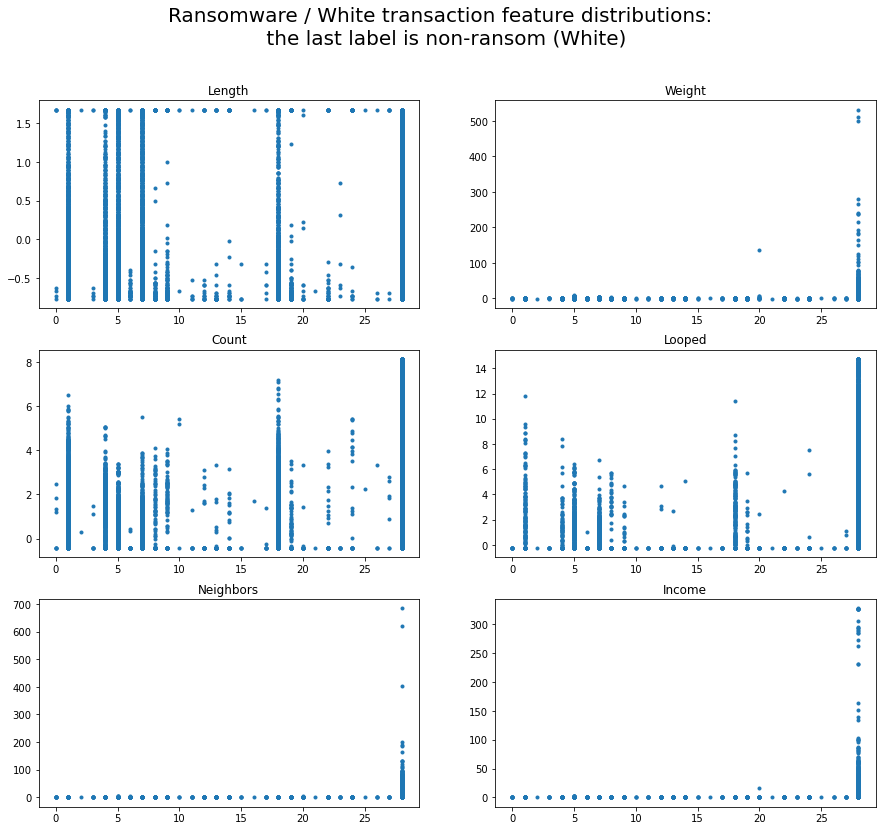

In [7]:
fig, axs = plt.subplots(3,2,figsize=(15,13))
fig.suptitle('Ransomware / White transaction feature distributions: \n the last label is non-ransom (White)',fontsize=20)
axs[0,0].plot(df.label, df['length'],marker='o',markersize=3,linestyle='')
axs[0,0].set_title('Length')
axs[0,1].plot(df.label, df['weight'],marker='o',markersize=3,linestyle='')
axs[0,1].set_title('Weight')
axs[1,0].plot(df.label, df['count'],marker='o',markersize=3,linestyle='')
axs[1,0].set_title('Count')
axs[1,1].plot(df.label, df['looped'],marker='o',markersize=3,linestyle='')
axs[1,1].set_title('Looped')
axs[2,0].plot(df.label, df['neighbors'],marker='o',markersize=3,linestyle='')
axs[2,0].set_title('Neighbors')
axs[2,1].plot(df.label, df['income'],marker='o',markersize=3,linestyle='')
axs[2,1].set_title('Income')

The figures above depict the feature distributions for each quantitative metric for each ransomware family or white transaction (post-scaling). As shown, weight, neighbors, and income have very little variance for ransomware families compared to non-ransomware. However, a few ransomware families seem to have significantly large distributions for the remaining variables even in comparison to white transactions. This being the case, we wanted to check the correlation between each variable to see if we can make any hypotheses about their relationships.

<AxesSubplot:>

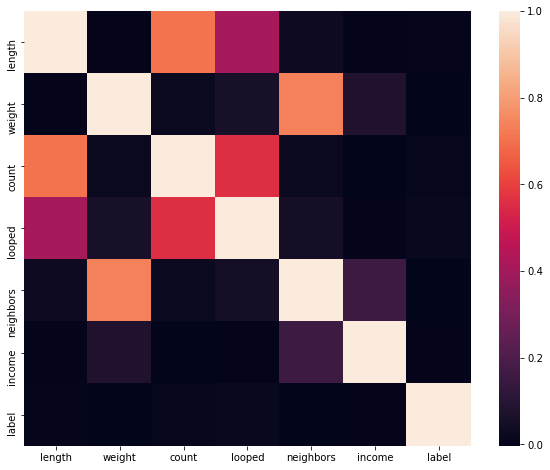

In [8]:
# heatmap of correlation between numerical variables plus label
plt.figure(figsize=(10,8))
sns.heatmap(df[to_standardize + ['label']].corr())

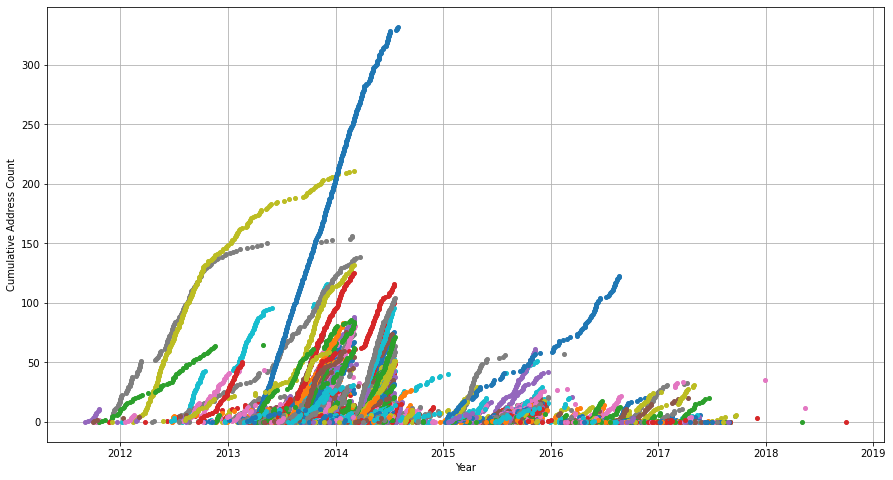

In [9]:
# how many of each address do we have from ransoms?
plt.figure(figsize=(15,8))
for name, group in ransom[['address','address_cumcount','date']].groupby('address'):
    plt.plot(group['date'],group['address_cumcount'],label=name,marker='o',markersize=4,linestyle='')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Cumulative Address Count')
plt.show()

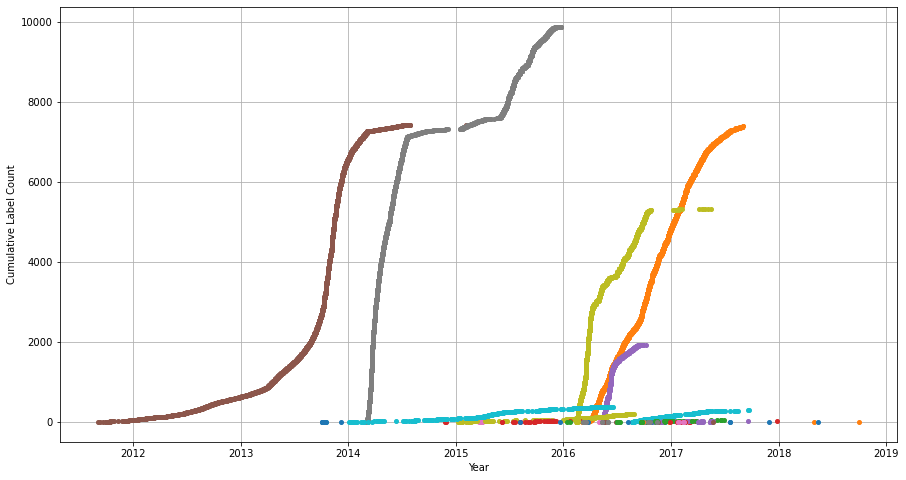

In [10]:
# how many of each ransom label do we have?
plt.figure(figsize=(15,8))
for name, group in ransom[['label','label_cumcount','date']].groupby('label'):
    plt.plot(group['date'],group['label_cumcount'],label=name,marker='o',markersize=4,linestyle='')
plt.grid()
plt.xlabel('Year',)
plt.ylabel('Cumulative Label Count')
plt.show()

<AxesSubplot:title={'center':'Time each Ransomware Family spent making Ransom Transactions'}, xlabel='label', ylabel='Time in Years'>

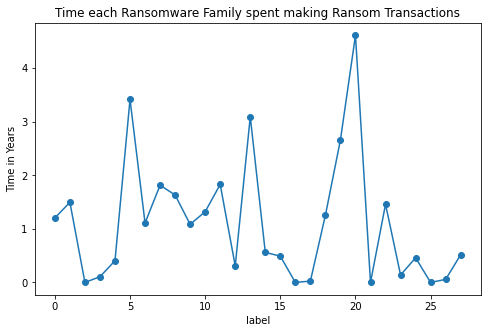

In [11]:
# which were the longest running ransomware families?
ransomGB = ransom.groupby('label')
family_time = ransomGB['date'].max() - ransomGB['date'].min()
family_time.plot(marker='o',figsize=(8,5),ylabel='Time in Years',
                title='Time each Ransomware Family spent making Ransom Transactions')

## Analysis

In [12]:
for n in np.arange(1,30,2):
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(ransom.drop('label',axis=1),ransom['label'])
    print('accuracy of '+str(n)+' neighbors: '+str((neigh.predict(ransom.drop('label',axis=1)) != ransom.label).sum() / ransom.shape[0]))

accuracy of 1 neighbors: 0.0
accuracy of 3 neighbors: 0.21146000181329141
accuracy of 5 neighbors: 0.2734141255402097
accuracy of 7 neighbors: 0.31040527063374534
accuracy of 9 neighbors: 0.3346127111728973
accuracy of 11 neighbors: 0.35156698600743447
accuracy of 13 neighbors: 0.3690048052222793
accuracy of 15 neighbors: 0.37958233854150925
accuracy of 17 neighbors: 0.39000876424189307
accuracy of 19 neighbors: 0.3999214240382
accuracy of 21 neighbors: 0.4069025960288918
accuracy of 23 neighbors: 0.417117471062891
accuracy of 25 neighbors: 0.42515639638550573
accuracy of 27 neighbors: 0.4332255432318898
accuracy of 29 neighbors: 0.43812143008250476


              count
CryptoWall     9872
CryptoLocker   7422
Cerber         7381


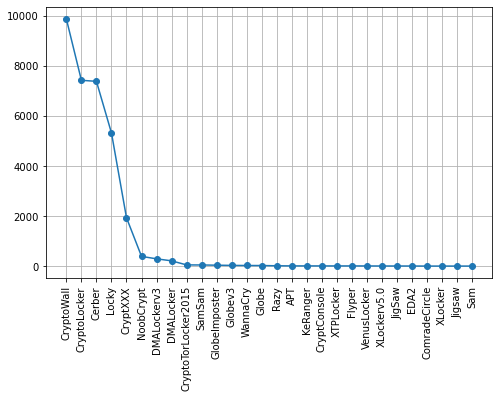

In [13]:
raw_ransom = raw_df[raw_df.label != 'white']
fig = raw_ransom.label.value_counts().plot(rot=90,figsize=(8,5),marker='o',grid=True)
fig.set_xticks(np.arange(len(raw_ransom.label.unique())))
fig.set_xticklabels(raw_ransom.label.value_counts().index.to_list())
print(pd.DataFrame({'count':raw_ransom.label.value_counts()[:3]}))